### Unfair coin tosses

Copyright Allen Downey 2018

[MIT License](https://opensource.org/licenses/MIT)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np

Here's a puzzle from [a recent FiveThirtyEight post](https://fivethirtyeight.com/features/how-far-would-you-go-to-rig-a-coin-flip/):

>Coin flips are a handy way to determine a winner — if the goal is to give two people an equal chance of winning. But sometimes it’s not. Suppose Anna and Barry aren’t interested in equity. All they have is a fair coin marked heads and tails. How can they devise a game that gives Anna a 1 in 3 chance of winning? What about a 1 in 4 chance? What about a 1 in 5 chance?



### Solution

The key to the solution is to take advantage of Pascal's triangle.  If you toss `n` coins, the number of heads, `k`, follows a binomial distribution.  The relative probabilities of the totals `k = 0...n` are the coefficients in Pascal's triangle.

Here's a function that uses `np.convolve` to generate the rows of Pascal's triangle.

In [2]:
def pascal(n_rows):
    a = [1]
    yield(a)
    
    for i in range(n_rows):
        a = np.convolve(a, [1,1])
        yield(a)

In [3]:
for row in pascal(5):
    print(row)

[1]
[1 1]
[1 2 1]
[1 3 3 1]
[1 4 6 4 1]
[ 1  5 10 10  5  1]


The third row is [1 2 1], which indicates that if we flip two coins, the chance of getting 1 head is twice the chance of getting 0 or 2 heads.  So if we want to give Anna a 1/4 chance of winning, we could toss two coins: if we get 0 heads, Anna wins; otherwise Barry wins.

More generally, we can toss `n` coins and choose

1. A set of totals where Anna wins,
2. A set of totals where Barry wins, and maybe
3. A leftover set where we have to toss again.

For example, if Anna should win `1/3` of the time, we could toss `2` coins; Anna wins if we get `0` heads, Barry wins if we get `1`, and we have to toss again if we get `2`.

The chance that we have to try again is `1/4`, so the expected number of attempts is `4/3`.  Each attempt requires 2 coins tosses, so the expected number of flips is `8/3`.

For each desired probability, we can search for the process that yields the desired outcome with the minimum expected number of flips.

I'll start with a function that yields all combinations from a set.

In [4]:
from itertools import combinations

def all_combos(s):
    n = len(s)
    for r in range(1, n+1):
        for comb in combinations(s, r):
            yield list(comb)

For example, if we take the third row from Pascal's triangle, there are three outcomes, `{0, 1, 2}`, with relative frequencies `[1, 2, 1]`.

In [5]:
row = np.array([1, 2, 1])
ind = set(range(len(row)))

{0, 1, 2}

Here are all subsets of the outcomes:

In [6]:
for comb in all_combos(ind):
    print(comb)

[0]
[1]
[2]
[0, 1]
[0, 2]
[1, 2]
[0, 1, 2]


Now we'd like to enumerate all partitions of the set into `win` and `lose`, allowing the possiblity of leaving out some outcomes.

In [7]:
def all_partitions(s):
    for win in all_combos(s):
        rest = s - set(win)
        for lose in all_combos(rest):
            yield win, lose

Here are the ways to partition `{0, 1, 2}`, and the total relative frequency for each subset.

In [8]:
for win, lose in all_partitions(ind):
    print(win, lose, row[win].sum(), row[lose].sum())

[0] [1] 1 2
[0] [2] 1 1
[0] [1, 2] 1 3
[1] [0] 2 1
[1] [2] 2 1
[1] [0, 2] 2 2
[2] [0] 1 1
[2] [1] 1 2
[2] [0, 1] 1 3
[0, 1] [2] 3 1
[0, 2] [1] 2 2
[1, 2] [0] 3 1


Now we can enumerate the rows of Pascal's triangle and for each set of outcomes, enumerate the partitions.

For each partition, we compute the odds Anna wins and yield:

* `expected_coins`: the expected total number of coins we have to toss.
* `n_coins`: number of coins we toss for each attempt
* `win`: set of outcomes where Anna wins
* `lose`: set of outcomes where Anna loses
* `odds`: the odds that Anna wins.


In [9]:
import math

def reduce(a, b):
    d = math.gcd(a, b)
    return a//d, b//d

In [10]:
from fractions import Fraction

def enumerate_rows(n_rows):
    # loop through the rows of Pascal's triangle
    for n_coins, row in enumerate(pascal(n_rows)):
        index = set(range(len(row)))
        
        # loop through ways to partition the outcomes
        for win, lose in all_partitions(index):
            
            # compute the odds Anna wins
            numer, denom = row[win].sum(), row[lose].sum()
            odds = reduce(numer, denom)

            # compute the expected number of tosses
            efficency = Fraction(numer + denom, 2**n_coins)
            expected_coins = n_coins / efficency
            
            yield expected_coins, n_coins, efficency, win, lose, odds

Here are the results from tossing one coin or two.

In [11]:
for result in enumerate_rows(2):
    print(result)

(Fraction(1, 1), 1, Fraction(1, 1), [0], [1], (1, 1))
(Fraction(1, 1), 1, Fraction(1, 1), [1], [0], (1, 1))
(Fraction(8, 3), 2, Fraction(3, 4), [0], [1], (1, 2))
(Fraction(4, 1), 2, Fraction(1, 2), [0], [2], (1, 1))
(Fraction(2, 1), 2, Fraction(1, 1), [0], [1, 2], (1, 3))
(Fraction(8, 3), 2, Fraction(3, 4), [1], [0], (2, 1))
(Fraction(8, 3), 2, Fraction(3, 4), [1], [2], (2, 1))
(Fraction(2, 1), 2, Fraction(1, 1), [1], [0, 2], (1, 1))
(Fraction(4, 1), 2, Fraction(1, 2), [2], [0], (1, 1))
(Fraction(8, 3), 2, Fraction(3, 4), [2], [1], (1, 2))
(Fraction(2, 1), 2, Fraction(1, 1), [2], [0, 1], (1, 3))
(Fraction(2, 1), 2, Fraction(1, 1), [0, 1], [2], (3, 1))
(Fraction(2, 1), 2, Fraction(1, 1), [0, 2], [1], (1, 1))
(Fraction(2, 1), 2, Fraction(1, 1), [1, 2], [0], (3, 1))


There are several ways to get `1:1` odds, but the most efficient is to toss one coin once.  No surprise there.

The best ways to get `1:2` odds (so far) is to toss 2 coins, but we might have to try several times, so the expected number of tosses is `8/3`, as in the example above.

No we can enumerate the rows of Pascal's triangle and for each effective odds, record the best way to achieve it.

`best` maps from `odds`, represented by a tuple of integers, to `results`, which is a tuple.

The elements of `results` are in order so we can use tuple comparison to select the results with the lowest expected number of coin tosses, and the lowest number of tosses per round, as a tie-breaker.

Exploring the first 11 rows of Pascal's triangle takes several seconds.


In [12]:
best = {}
absent = (np.inf,)

for result in enumerate_rows(10):
    odds = result[-1]
    t = best.get(odds, absent)
    if result < t:
        best[odds] = result

Here are the results:

In [13]:
res = []

for denom in range(1, 40):
    result = best[1, denom]
    expected_coins, n_coins, efficiency, win, lose, odds = result
    print(odds, n_coins, efficiency, expected_coins, win, lose)
    res.append((denom, efficiency, expected_coins))

(1, 1) 1 1 1 [0] [1]
(1, 2) 2 3/4 8/3 [0] [1]
(1, 3) 2 1 2 [0] [1, 2]
(1, 4) 3 5/8 24/5 [0] [1, 3]
(1, 5) 4 3/4 16/3 [0, 4] [1, 2]
(1, 6) 3 7/8 24/7 [0] [1, 2]
(1, 7) 3 1 3 [0] [1, 2, 3]
(1, 8) 6 63/64 128/21 [0, 1] [2, 3, 4, 5]
(1, 9) 4 5/8 32/5 [0] [1, 3, 4]
(1, 10) 4 11/16 64/11 [0] [1, 2]
(1, 11) 4 3/4 16/3 [0] [1, 2, 4]
(1, 12) 9 247/256 2304/247 [0, 2, 9] [3, 4, 5, 6, 7]
(1, 13) 7 49/64 64/7 [1] [2, 3, 4]
(1, 14) 4 15/16 64/15 [0] [1, 2, 3]
(1, 15) 4 1 4 [0] [1, 2, 3, 4]
(1, 16) 7 119/128 128/17 [1] [2, 3, 4, 5]
(1, 17) 7 63/64 64/9 [1] [2, 3, 4, 5, 6]
(1, 18) 6 19/32 192/19 [0, 6] [1, 2, 4]
(1, 19) 8 25/32 256/25 [0, 1, 8] [2, 3, 4, 6, 7]
(1, 20) 5 21/32 160/21 [0] [1, 2, 4]
(1, 21) 5 11/16 80/11 [0] [1, 2, 4, 5]
(1, 22) 8 23/32 256/23 [1] [2, 3, 5, 6, 7]
(1, 23) 8 3/4 32/3 [1] [0, 2, 3, 4, 6, 8]
(1, 24) 9 475/512 4608/475 [0, 1, 8] [2, 3, 4, 5, 6]
(1, 25) 5 13/16 80/13 [0] [1, 2, 3]
(1, 26) 5 27/32 160/27 [0] [1, 2, 3, 5]
(1, 27) 6 7/16 96/7 [0] [1, 2, 5]
(1, 28) 6 29/32 192/29

The fourth line is `(1, 4) 3 5/8 24/5 [0] [1, 3]`, which indicates that if we want odds `1:4`, we should flip `3` coins.  Alice wins if we get `0` heads; Barry wins if we get `1` or `3`.  `5/8` of the time we are done; the remaining `3/8` we flip again; on average we expect to toss `24/5` coins. 

Let's see what the results look like graphically.  Here's efficiency for each value of odds against.

In [14]:
odds, effs, coins = np.array(res).T

In [15]:
import matplotlib.pyplot as plt

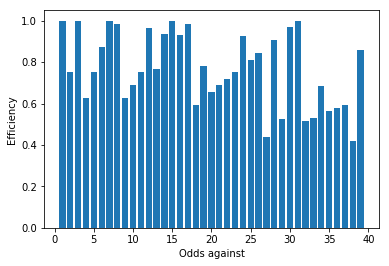

In [16]:
plt.bar(odds, effs)
plt.xlabel('Odds against')
plt.ylabel('Efficiency');

And here's the expected number of coin tosses for each value of odds against.

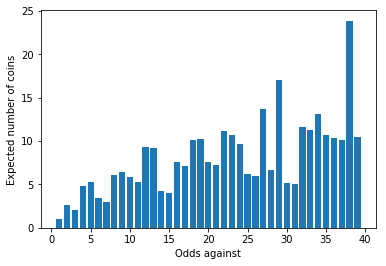

In [17]:
plt.bar(odds, coins)
plt.xlabel('Odds against')
plt.ylabel('Expected number of coins');

We can also visualize the efficiency for all values of odds, not just `1:k`.

In [19]:
zs = np.full((40, 40), np.nan)
for odds, result in best.items():
    expected_coins = result[0]
    efficiency = result[2]
    try:
        zs[odds] = efficiency
    except IndexError:
        pass

/home/downey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Fraction.__float__ returned non-float (type numpy.float64).  The ability to return an instance of a strict subclass of float is deprecated, and may be removed in a future version of Python.
  


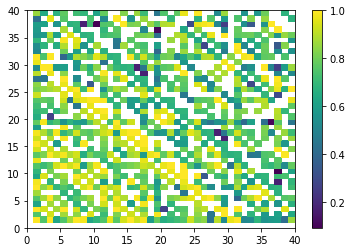

In [20]:
plt.pcolormesh(zs)
plt.colorbar();

Interestingly, it seems that odds we can obtain efficiently come in diagonal stripes, with the exception of a few unlucky pairs with low efficiencies.